In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

Using cupy


In [2]:
nx = 800
ny = 400
steps = 150000
output_stride = 1500
profile_interval = 1500

In [3]:
molecular_weights = np.array([1,80, 17, 8]) # H2, TMIn, PH3, CH4
n_species = len(molecular_weights)
multiplier = 3.64# 5.46 # for n = 400 (500nm)

phi_1 = 0.78
phis = phi_1 * molecular_weights[0]/molecular_weights
print(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

[0.78       0.00975    0.04588235 0.0975    ]
viscosity_kinematic =  0.4981028326194333


In [4]:
D_s = 1/(multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights))
print('D_s = ',D_s)

D_s =  [0.38852021 0.27643698 0.28268998 0.29139016]


In [5]:
vx = 3.3e-6
v_top = xp.array([vx, 0])
#c_top = xp.array([0.979, 0.0047, 0.0204, 1e-4])
#c_top = xp.array([0.978, 0.0027, 0.017, 0.011])
c_top = xp.array([0.979, 0.000047, 0.0204, 1e-10])
print("ratio = ", c_top[2]/c_top[1])
print(np.sum(c_top))
absorption_ratio = xp.array([0,1,1,-3])
print(3*c_top)

ratio =  434.04255319148945
0.9994470001
[2.937e+00 1.410e-04 6.120e-02 3.000e-10]


In [6]:
L_grid = 5e-7
c_w_ratio_guess = 0.5
target_norm_slope = 65
b1_estimate = c_w_ratio_guess/target_norm_slope/L_grid
print(b1_estimate)

15384.615384615387


nx_ratio =  1000.0
40.0


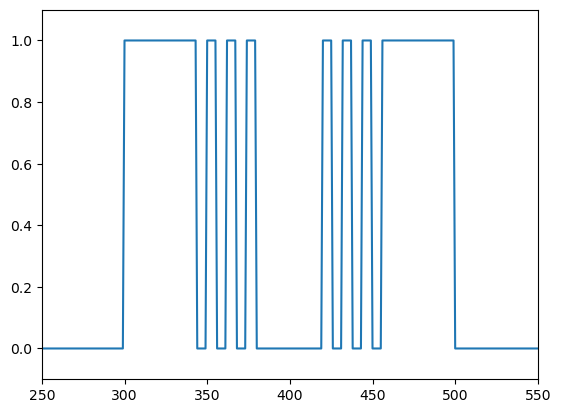

In [12]:
absorption_coefficient = 15384

L_grid = 0.5

nx_ratio = 500/0.5
print('nx_ratio = ',nx_ratio)

L_gap = 20 //L_grid
L_mask1 = 3//L_grid
L_mask2 = 3//L_grid
L_mask_side = 40//L_grid-3*(L_mask1+L_mask2)

print(L_gap)

non_absorb_mask = xp.zeros(nx)
non_absorb_mask[nx//2+L_gap//2 : nx//2+L_gap//2+L_mask1] = True
non_absorb_mask[nx//2+L_gap//2+L_mask1+L_mask2 : nx//2+L_gap//2+2*L_mask1+L_mask2] = True
non_absorb_mask[nx//2+L_gap//2+2*L_mask1+2*L_mask2 : nx//2+L_gap//2+3*L_mask1+2*L_mask2] = True
non_absorb_mask[nx//2+L_gap//2+3*L_mask1+3*L_mask2 : nx//2+L_gap//2+3*L_mask1+3*L_mask2+L_mask_side] = True

non_absorb_mask[0: nx//2] = non_absorb_mask[nx//2:][::-1]

plt.plot(to_numpy(non_absorb_mask))
plt.ylim([-0.1, 1.1])
plt.xlim([250,550])

comp2_bc = xp.array([absorption_coefficient, 1, 0])

In [13]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
    D_s=xp.array(D_s),
    v_top = v_top, # vx, vy
    c_top = c_top, # partial pressure
    non_absorb_mask=xp.array(non_absorb_mask),
    comp2_bc =comp2_bc,
    absorption_ratio = xp.array(absorption_ratio),
)

In [14]:
vx_ini = vx
total_pressure = 1
partial_pressure = c_top

y_coord = xp.arange(ny)
velocity_profile = vx_ini * y_coord/ny

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, lbm_config, ux_s, uy_s)
f = feq

f_cross_ini = feq[:, :, nx//2, :]

f_end = None

In [15]:
def main(f, lbm_config):
    velocity_field = []
    clip_history = []
    f_cross = []
    for step in tqdm(range(lbm_config.steps + 1)):
        if step % output_stride == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, lbm_config)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            #velocity_field.append((ux_s, uy_s))
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 10000, skip = nx//40, save = True)
            save_concentration_frames(f, step, lbm_config)
            #plt.plot(to_numpy(rho_s[1, :, 0]))
            #plt.show()
            np.save("f_mask_intermediate", f)

        f, clipped = bgk_step(f, lbm_config, top_moving_left_intake_bottom_absorb_4_species)

        clip_history.append(clipped)
        if step % profile_interval == 0:
            f_cross.append(f[1, :, nx//2, :])

        if step == steps:
            break

    return np.array(velocity_field), np.array(clip_history), to_numpy(xp.array(f_cross)), to_numpy(f)

In [16]:
try:
    f = xp.array(f_end)
    print("continue from previous result")
except:
    print("no previous result")
velocity_field,clip_history, f_cross, f_end = main(f, lbm_config)
np.save("f_sample_simulation", f_end)

no previous result


100%|█████████▉| 150000/150001 [1:18:27<00:00, 31.87it/s]


(4, 9, 800, 400)
(4, 800, 400)
52226.06256742179


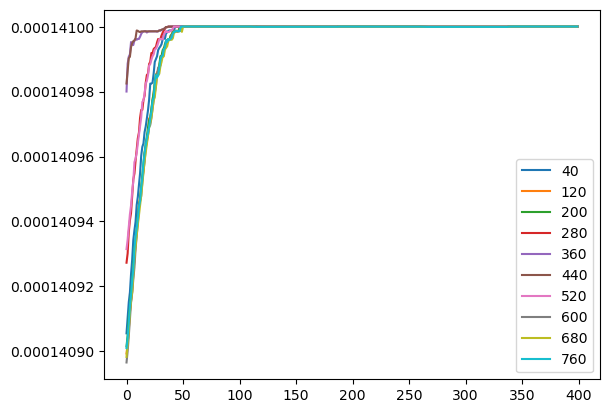

In [17]:
print(f_end.shape)
rho_s = xp.sum(f_end, axis = 1, dtype = DTYPE)
print(rho_s.shape)
for i in range(10):
    plt.plot(rho_s[1, i*(nx//10)+nx//20, :], label = f'{i*(nx//10)+nx//20}')
plt.legend()

slope = (rho_s[1, nx//2, 5]-rho_s[1, nx//2, 0])/5
b1_measured = rho_s[1, 50, 0]/slope
print(b1_measured)

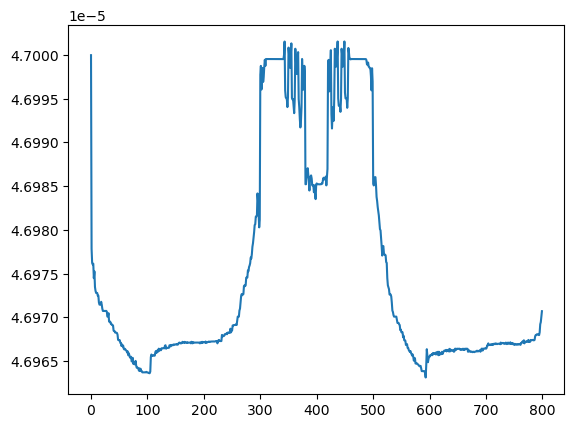

In [18]:
plt.plot(rho_s[1,:,0]/3)
#plt.xlim([250,550])

(250.0, 550.0)

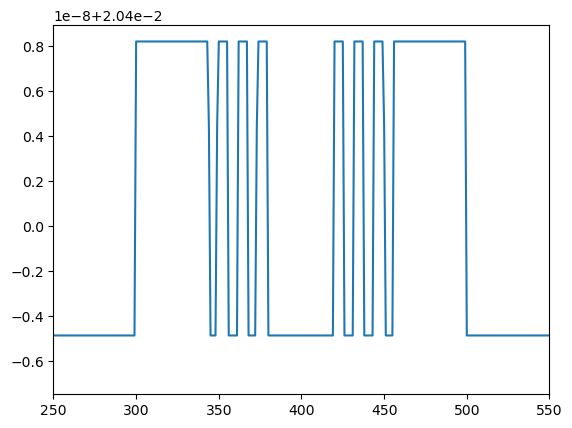

In [19]:
plt.plot(rho_s[2,:,0]/3)
plt.xlim([250,550])
#plt.ylim([0, 2*np.max(rho_s[2,250:550,0]/3)])

(350.0, 450.0)

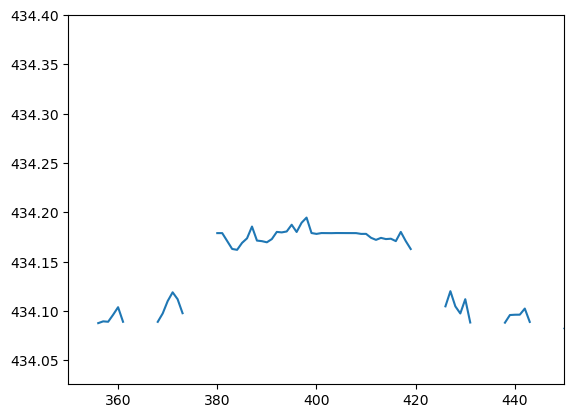

In [20]:
c_ratio = rho_s[2,:,0]/rho_s[1,:,0]
c_ratio[to_numpy(non_absorb_mask)==1] = np.nan
plt.plot(c_ratio)
plt.xlim([350,450])

In [21]:
slope2 = (rho_s[1, nx//2, 5]-rho_s[1, nx//2, 0])/5
flux2 = slope2 * D_s[1]
#print(flux2)
slope3 = (rho_s[2, nx//2, 5]-rho_s[2, nx//2, 0])/5
flux3 = slope3 * D_s[2]
print(flux3/flux2)
slope4 = (rho_s[3, nx//2, 5]-rho_s[3, nx//2, 0])/5
flux4 = slope4 * D_s[3]
print(flux4/flux2)

2.824063820854755
-8.136170293263586


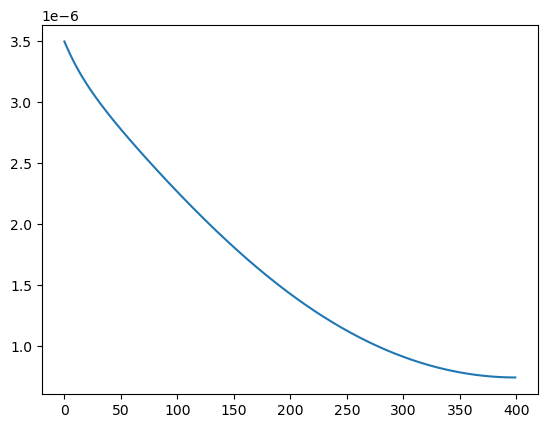

In [22]:
plt.plot(rho_s[3, nx//2, :])

(101, 9, 400)
(100,)


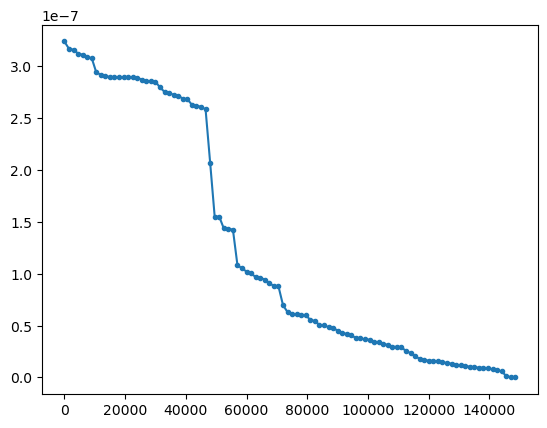

In [24]:
err = []
print(f_cross.shape)
for i in range(f_cross.shape[0]-1):
    error = np.sum(np.abs(f_cross[-i-1] - f_cross[-1]))
    err.append(error)
err = np.array(err)
print(err.shape)
plt.plot(np.arange(len(err))*profile_interval, err[::-1], marker = ".")

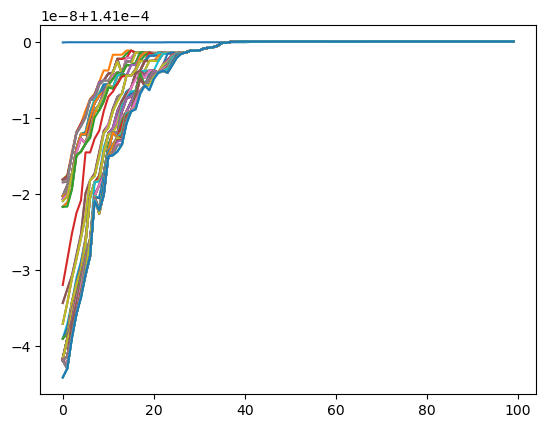

In [28]:
y_concentration_profile = np.sum(np.array(f_cross), axis = 1)
for i in range(y_concentration_profile.shape[0]):
    plt.plot(y_concentration_profile[i, :100])

(101, 9, 400)
(100,)


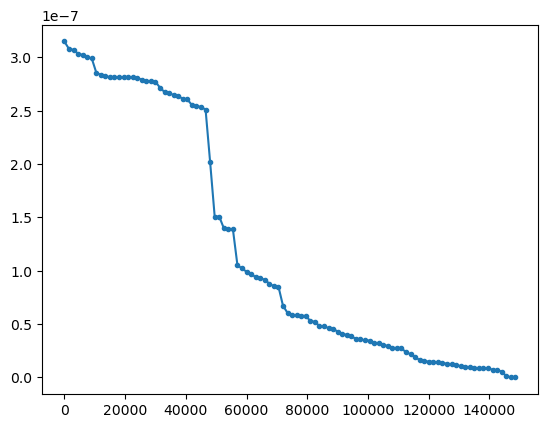

In [29]:
err = []
print(f_cross.shape)
for i in range(y_concentration_profile.shape[0]-1):
    error = np.sum(abs(y_concentration_profile[-i-1, :100] - y_concentration_profile[-1, :100]))
    err.append(error)
err = np.array(err)
print(err.shape)
plt.plot(np.arange(len(err))*profile_interval, err[::-1], marker = ".")

(-0.1, 1.1)

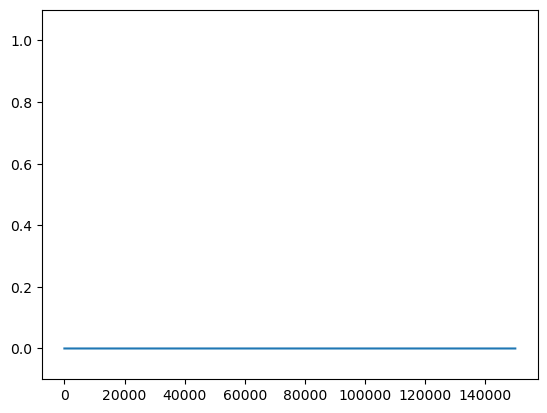

In [25]:
plt.plot(clip_history)
plt.ylim([-0.1, 1.1])